## KL Expansion for Elliptic PDE 1d 

From Section 4.3.1 of Rasmussen and Williams GP4ML book, 

$$v(x) = \sum_{i \geq 0} z_i \phi_i(x)$$
where $z_i \sim \mathcal{N}(0,\lambda_i)$ are IID with
$$\lambda_i = \sqrt{\frac{2a}{A}} B^i$$
and 
$$\phi_i(x) = \exp(-(c-a)x^2)H_i(\sqrt{2c}x)$$
where $H_i$ is the $i^\text{th}$ order Hermite polynomial, $a^{-1}=4\sigma^2$, $b^{-1} =2\ell^2$, $c=\sqrt{a^2+2ab}$, $A=a+b+c$, and $B=b/A$. 

In [1]:
import torch
import numpy as np
import qmcpy as qp
import pandas as pd
from matplotlib import pyplot

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

In [3]:
torch.set_default_dtype(torch.float64)

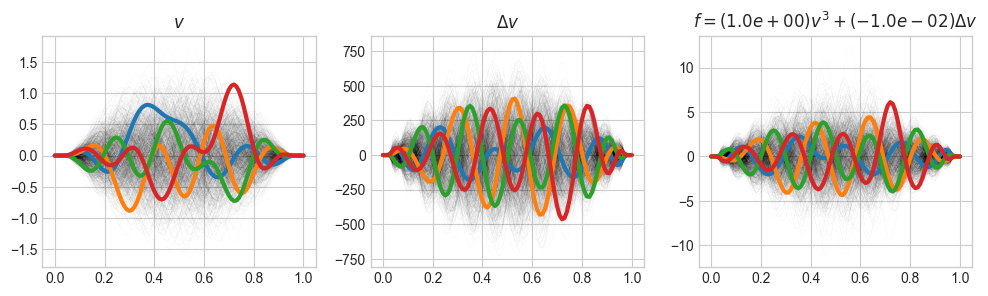

In [4]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**10
P = 10
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 101
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
coloridxs = torch.arange(4)
ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
ax[0].set_title(r"$v$")
ax[1].set_title(r"$\Delta v$")
ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

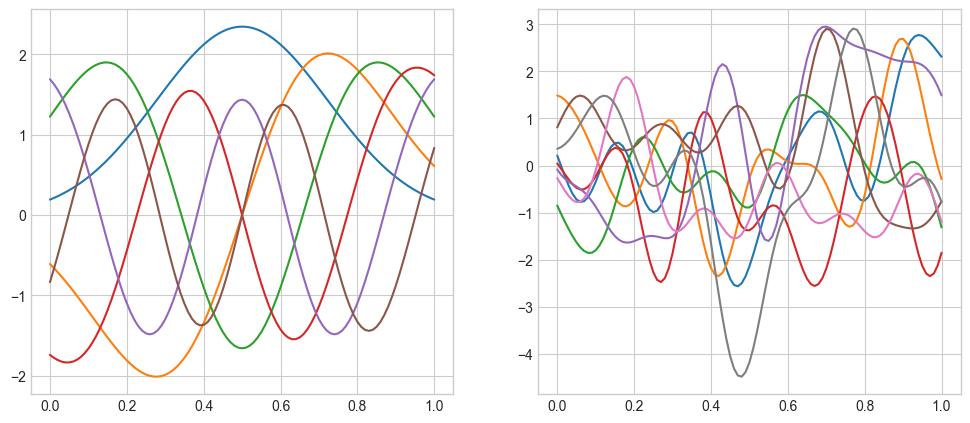

In [8]:
class GaussKL:
    # Section 4 of https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=b2d5fff7600abe81da7b1e5af749ed9511867aed
    # Section 4.3.1 of https://gaussianprocess.org/gpml/chapters/RW.pdf
    def __init__(self, sigma=1e0, ell=5e-2, center=.5):
        self.a = 1/(4*sigma**2)
        self.b = 1/(2*ell**2)
        self.c = np.sqrt(self.a**2+2*self.a*self.b)
        self.A = self.a+self.b+self.c 
        self.B = self.b/self.A 
        self.center = center
    def phi(self, xin, i):
        x = xin-self.center
        y = torch.exp(-self.c*x**2)*torch.special.hermite_polynomial_h(np.sqrt(2*self.c)*x,i)
        const = np.sqrt(np.pi)*torch.exp(i*np.log(2)+torch.lgamma(i+1))/(self.c-self.a)
        return y/torch.sqrt(const)
    def lam(self, i):
        return np.sqrt(np.pi/self.A)*self.B**i
    def sample_from_z(self, xin, z):
        T = z.size(-1)
        i = torch.arange(T)
        lams = self.lam(i)
        phis = self.phi(xin[:,None],i)
        y = torch.einsum("t,rt,it->ri",torch.sqrt(lams),z,phis)
        return y
    
gkl = GaussKL()
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].plot(xticks,gkl.phi(xticks[:,None],torch.arange(6,dtype=int)))
ax[1].plot(xticks,gkl.sample_from_z(xticks,torch.randn(8,32)).T);

In [21]:
T = 128
xticks_g = xticks.clone().requires_grad_()
phi_g = gkl.phi(xticks_g[:,None],torch.arange(T))
phi_grad_g = torch.vstack([torch.autograd.grad(phi_g[:,t],xticks_g,grad_outputs=torch.ones(nxticks),create_graph=True,retain_graph=True)[0] for t in range(T)]).T
phi_lap_g = torch.vstack([torch.autograd.grad(phi_grad_g[:,t],xticks_g,grad_outputs=torch.ones(nxticks),create_graph=True,retain_graph=True)[0] for t in range(T)]).T
lam = gkl.lam(torch.arange(T))
phi = phi_g.detach()
phi_grad = phi_grad_g.detach()
phi_lap = phi_lap_g.detach()
phi.abs().mean(),phi_grad.abs().mean(),phi_lap.abs().mean()

(tensor(0.5440), tensor(2.7128), tensor(13.5194))

In [22]:
def P(z, u):
    v = (z*phi*lam).sum(1)
    v_lap = (z*phi_lap*lam).sum(1)
    eq1 = C1*v**3+C2*v_lap-u
    eq2 = v[[0,-1]]
    return torch.hstack([eq1,eq2])

Iter 100/800 - Loss: 106.667
Iter 200/800 - Loss: 98.792
Iter 300/800 - Loss: 93.783
Iter 400/800 - Loss: 91.134
Iter 500/800 - Loss: 89.305
Iter 600/800 - Loss: 87.550
Iter 700/800 - Loss: 85.260
Iter 800/800 - Loss: 81.457
tensor([ 1.0066e-01, -1.8097e+00, -1.2228e+00,  1.0168e+00, -9.5718e-01,
        -4.0279e-01,  4.6169e-01,  8.0957e-01, -1.0428e+00, -3.0243e-01,
         9.5753e-01, -1.9181e+00,  3.1818e-01, -3.8628e-01, -1.1874e+00,
        -1.3170e+00, -1.4225e+00,  7.4676e-01,  8.0633e-01, -1.5706e+00,
         5.6790e-01, -1.5377e+00,  2.4565e+00, -1.7927e+00, -9.3859e-01,
         1.9390e+00,  5.5529e-01, -4.8725e-01, -2.2461e-03,  1.8837e+00,
         1.4425e+00, -1.3551e+00,  8.3116e-02, -1.4100e+00,  7.8778e-01,
        -1.3268e-01,  8.9348e-01,  1.0630e+00, -2.4788e+00,  4.1318e-01,
         2.3738e+00,  9.4921e-01,  3.3701e-01, -1.8647e+00, -2.6241e+00,
        -4.4285e-01,  3.8237e-01, -2.5000e-01, -6.4739e-01, -4.8085e-02,
        -1.0719e-01,  1.5442e+00,  2.6413e+00

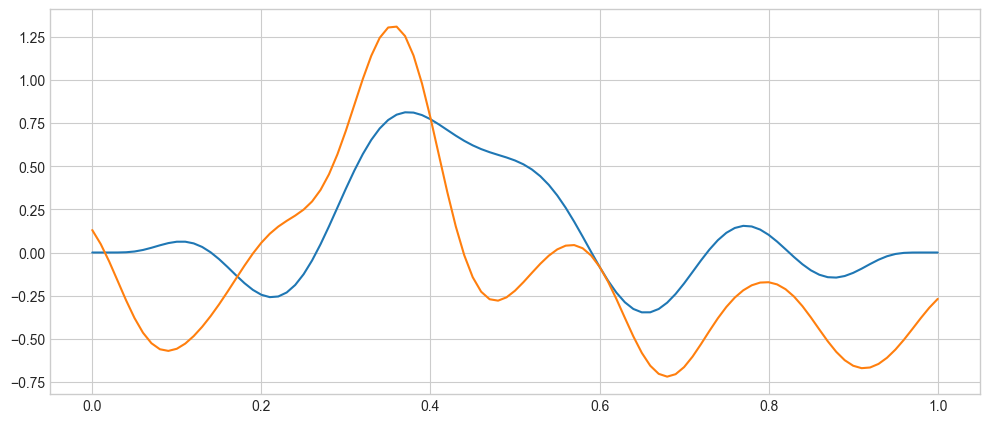

In [23]:
training_iterations = 800
z_g = torch.randn(T,requires_grad=True)
optimizer = torch.optim.Adam([z_g], lr=1e-3)
verbosity = max(1,int(training_iterations/8))
for i in range(training_iterations):
    optimizer.zero_grad()
    y_g = P(z_g,uticks[0])
    loss = y_g@y_g
    loss.backward()
    if (i+1)%verbosity==0: print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
print(z_g)
vhat = (z_g.detach()*lam*phi).sum(-1)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(12,5))
ax.plot(xticks,vticks[0])
ax.plot(xticks,vhat);

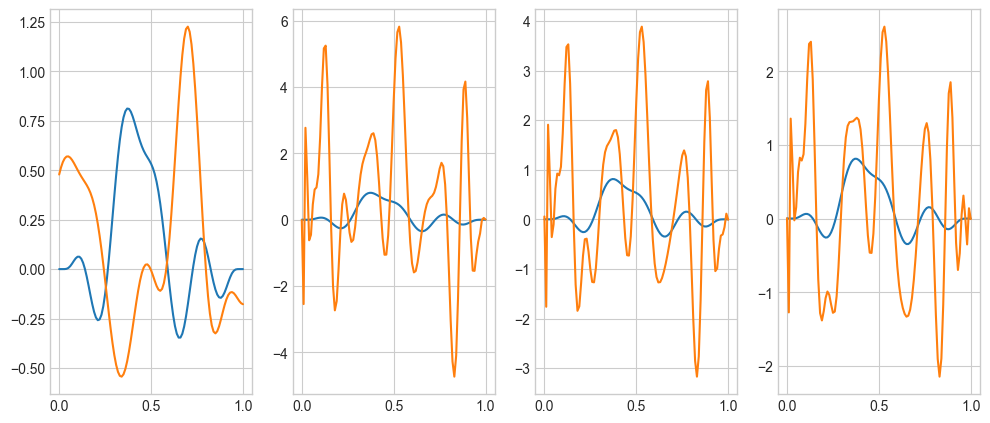

In [9]:
maxiter = 3
z_g = torch.randn(T,requires_grad=True)
zhist = torch.empty((maxiter+1,T))
zhist[0] = z_g.detach().clone()
for k in range(maxiter):
    y_g = P(z_g,uticks[0])
    D_g = torch.vstack([torch.autograd.grad(y_g[i],z_g,retain_graph=True)[0] for i in range(y_g.size(0))])
    z = z_g.detach()
    y = y_g.detach()
    D = D_g.detach()
    lstsq_sol = torch.linalg.lstsq(D,D@z-y)
    zhist[k+1] = lstsq_sol.solution.clone()
    z_g = lstsq_sol.solution.requires_grad_()
vhats = (zhist[:,None,:]*lam*phi).sum(-1)
fig,ax = pyplot.subplots(nrows=1,ncols=maxiter+1,figsize=(12,5))
for k in range(maxiter+1):
    ax[k].plot(xticks,vticks[0])
    ax[k].plot(xticks,vhats[k])